In [1]:
import os
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Load Results and Errors

In [2]:
# Load Sample Prediction Tracks
TRACK_DIR = os.path.join(os.getcwd(), 'tracks/72.7_amota.json')
with open(TRACK_DIR, "r") as file:
    pred_json = json.load(file)

# Load Track Evaluation Errors
ERRORS_DIR = os.path.join(os.getcwd(), 'results/72.7_amota/errors.json')
with open(ERRORS_DIR, "r") as file:
    errors_json = json.load(file)


# How to Index Scenes in Error File

In [9]:
# Define Parameters
class_id = 'car'
thresh = 'thr_0.2059'
scene_token ='325cef682f064c55a255f2625c533b75'

scene_id_errors = errors_json[class_id][thresh][scene_token]
print("Num SWITCH: ", scene_id_errors['num_switch'])
print("Num MISS: ", scene_id_errors['num_miss'])
print("Num FP: ", scene_id_errors['num_fp'])
print("Num Fragmentation: ", scene_id_errors['num_frag'])
print("Num of Frames in Scene: ", len(scene_id_errors['frame_errors']))

print("\n")

print(json.dumps(scene_id_errors['frame_errors'][15], indent=4))

Num SWITCH:  53
Num MISS:  243
Num FP:  105
Num Fragmentation:  24
Num of Frames in Scene:  41


{
    "SWITCH": [
        {
            "type": "SWITCH",
            "object_id": "fd4ce422e0db4ad3ab978a811ba04d3a",
            "hypothesis_id": 130514.0,
            "distance": 0.2227465954491902,
            "gt": {
                "num_pts": 5,
                "size": [
                    1.639,
                    4.184,
                    1.604
                ],
                "rotation": [
                    -0.36266218378227394,
                    0.0,
                    0.0,
                    0.9319206728334082
                ],
                "velocity": [
                    -0.13503132473920182,
                    -0.10402413165076208
                ],
                "translation": [
                    677.518,
                    1807.347,
                    1.271
                ],
                "ego_translation": [
                    -21.36628562875694,


# Define Object of Interest

In [48]:
sample_id = '8092909473464f80b9f791a4d31ddcb8'
object_id = '34daad97663c4e8ea00f842adc581ab5'
hypothesis_id = int(scene_id_errors['frame_errors'][18]['SWITCH'][0]["hypothesis_id"])
print("Hypothesis:", hypothesis_id)

Hypothesis: 130752


# Find Prediction in Results File

In [49]:
sample_pred = pred_json['results'][sample_id]

# Find Hypothesis
obj_info = None
found_obj = False
for pred in sample_pred:
    if pred['tracking_id'] == hypothesis_id:
        obj_info = pred
        found_obj = True
        break

if found_obj:
    print(json.dumps(obj_info, indent=4))
else:
    print("Could not find prediction")

{
    "sample_token": "8092909473464f80b9f791a4d31ddcb8",
    "translation": [
        694.7005027765305,
        1800.104763791284,
        1.6289010289053485
    ],
    "size": [
        1.7782560586929321,
        4.133118629455566,
        1.5028159618377686
    ],
    "rotation": [
        -0.9291165032796782,
        0.011527242230352567,
        0.009213769509576128,
        -0.36949256077941817
    ],
    "velocity": [
        2.822072143915601e-06,
        5.247927810060138e-07
    ],
    "tracking_name": "car",
    "tracking_score": 0.007263509090989828,
    "tracking_id": 130752,
    "attribute_name": "vehicle.parked"
}


# Find Ground Truth

In [51]:
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-trainval', verbose=True, dataroot='dataset/nuscenes')

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading NuScenes tables for version v1.0-trainval...
Loading table: sample_annotation.pkl
Loading table: ego_pose.pkl
Loading table: sample_data.pkl
Loading table: category.json
Loading table: attribute.json
Loading table: visibility.json
Loading table: instance.json
Loading table: sensor.json
Loading table: calibrated_sensor.json
Loading table: log.json
Loading table: scene.json
Loading table: sample.json
Loading table: map.json
Loading nuScenes-lidarseg...
Loading table: lidarseg.json
Loading table: lidarseg.json
Loading nuScenes-panoptic...
Loading table: panoptic.json
Loading table: panoptic.json
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
34149 panoptic,
Done loading in 34.850 seconds.
Reverse indexing ...
Done reverse indexing in 7.9 seconds.


In [52]:
# The instance token gets you the object in every frame it is annotated in
gt_instance = nusc.get('instance', object_id)
print(json.dumps(gt_instance, indent=4))

{
    "token": "34daad97663c4e8ea00f842adc581ab5",
    "category_token": "fd69059b62a3469fbaef25340c0eab7f",
    "nbr_annotations": 27,
    "first_annotation_token": "204f3df0559a4f5da0f5f523f680e230",
    "last_annotation_token": "12af6002f65a48e4bdead64ce240626b"
}


In [53]:
# Get the ground truth for the prediction at the specific frame
gt_sample = nusc.get('sample', sample_id)
gt_anno = None
# Iterate through the annotations in the sample frame
for anno in gt_sample['anns']:
    nusc_anno = nusc.get('sample_annotation', anno)
    if nusc_anno['instance_token'] == object_id:
        gt_anno = nusc_anno
print(json.dumps(gt_anno, indent=4))

{
    "token": "09496c614c6947ef9c30996dcf28c620",
    "sample_token": "8092909473464f80b9f791a4d31ddcb8",
    "instance_token": "34daad97663c4e8ea00f842adc581ab5",
    "visibility_token": "2",
    "attribute_tokens": [
        "58aa28b1c2a54dc88e169808c07331e3"
    ],
    "translation": [
        695.003,
        1800.251,
        0.783
    ],
    "size": [
        1.862,
        4.923,
        1.588
    ],
    "rotation": [
        0.9296897227433863,
        0.0,
        0.0,
        0.3683436159692812
    ],
    "prev": "4612234f9add44da8d9ef9e0db97e673",
    "next": "2efeca4ab2d245aa9d0f1e9bdb903123",
    "num_lidar_pts": 83,
    "num_radar_pts": 0,
    "category_name": "vehicle.car"
}


# Compute Statistics of Interest

1. Average Number of Ground Truth Lidar Points per ['MISS', 'SWITCH']
2. Distribution of Visibility Token for ['MISS', 'SWITCH']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 12.34it/s]


,Avg Pts - MISS,Avg Pts - SWITCH,Median Pts - MISS,Median Pts - SWITCH
Thresholds,,,,
thr_0.0005,83.2761,10.8915,2,4
thr_0.0475,61.2576,10.9861,2,4
thr_0.0939,52.9112,10.8638,2,5
thr_0.1314,47.2591,12.1895,2,6
thr_0.1680,41.1542,12.2206,2,6
thr_0.2059,36.5595,13.9162,2,7
thr_0.2369,33.0189,15.162,3,7
thr_0.2680,31.2092,17.3571,3,9
thr_0.2955,31.6325,18.57,3,9


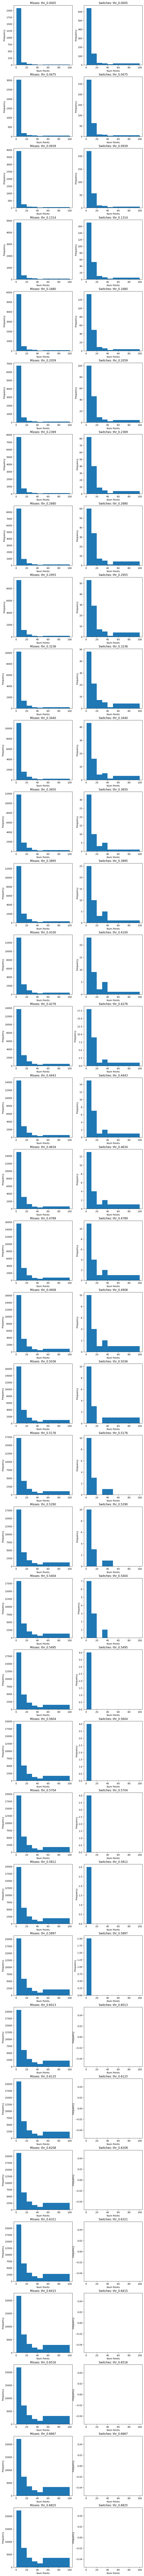

In [61]:
# 1. Average Number of Points per ['MISS', 'SWITCH', 'FP']
threshs = errors_json[class_id].keys()
metrics = ['Avg Pts - MISS', 'Avg Pts - SWITCH', 'Median Pts - MISS', 'Median Pts - SWITCH']
df = pd.DataFrame(index=pd.Index(threshs, name='Thresholds'),
                  columns=pd.Index(metrics))

fig, axs = plt.subplots(nrows=len(threshs), ncols=2, figsize=(10,200))
i = 0

bins = [1,10,20,30,40,50,100]

for t in tqdm(threshs):
    pts_misses = []
    pts_switch = []
    scenes = errors_json[class_id][t].keys()
    for s in scenes:
        for e in errors_json[class_id][t][s]['frame_errors']:
            
            for sw in e['SWITCH']:
                # Dont count if num pts not provided
                if sw['gt']['num_pts'] != -1:
                    pts_switch.append(sw['gt']['num_pts'])
            for m in e['MISS']:
                # Dont count if num pts not provided
                if m['gt']['num_pts'] != -1:
                    pts_misses.append(m['gt']['num_pts'])
    if len(pts_misses) > 0:
        df.loc[t, metrics[0]] = np.mean(pts_misses)
        df.loc[t, metrics[2]] = np.median(pts_misses)
    if len(pts_switch) > 0:
        df.loc[t, metrics[1]] = np.mean(pts_switch)
        df.loc[t, metrics[3]] = np.median(pts_switch)
            
    axs[i,0].hist(pts_misses, bins=bins)
    axs[i,0].set_title('Misses: {}'.format(t))
    axs[i,0].set_xlabel('Num Points')
    axs[i,0].set_ylabel('Frequency')
    axs[i,1].hist(pts_switch, bins=bins)
    axs[i,1].set_title('Switches: {}'.format(t))
    axs[i,1].set_xlabel('Num Points')
    axs[i,1].set_ylabel('Frequency')
    i+=1
df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:32<00:00,  1.12it/s]


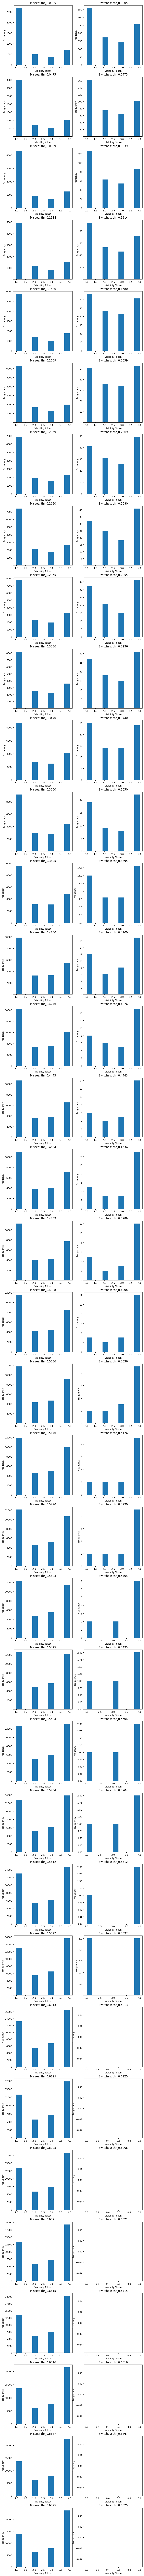

In [68]:
# 2. Distribution of Visibility Token for ['MISS', 'SWITCH']
threshs = errors_json[class_id].keys()

fig, axs = plt.subplots(nrows=len(threshs), ncols=2, figsize=(10,200))
i = 0

for t in tqdm(threshs):
    vis_misses = []
    vis_switch = []
    scenes = errors_json[class_id][t].keys()
    for s in scenes:
        for e in errors_json[class_id][t][s]['frame_errors']:
            
            for sw in e['SWITCH']:
                gt_sample = nusc.get('sample', e['sample_token'])
                gt_anno = None
                for anno in gt_sample['anns']:
                    nusc_anno = nusc.get('sample_annotation', anno)
                    if nusc_anno['instance_token'] == sw['object_id']:
                        gt_anno = nusc_anno
                        if 'visibility_token' in gt_anno.keys():
                            vis_switch.append(int(gt_anno['visibility_token']))
            for m in e['MISS']:
                gt_sample = nusc.get('sample', e['sample_token'])
                gt_anno = None
                for anno in gt_sample['anns']:
                    nusc_anno = nusc.get('sample_annotation', anno)
                    if nusc_anno['instance_token'] == m['object_id']:
                        gt_anno = nusc_anno
                        if 'visibility_token' in gt_anno.keys():
                            vis_misses.append(int(gt_anno['visibility_token']))

    axs[i,0].hist(vis_misses)
    axs[i,0].set_title('Misses: {}'.format(t))
    axs[i,0].set_xlabel('Visibility Token')
    axs[i,0].set_ylabel('Frequency')
    axs[i,1].hist(vis_switch)
    axs[i,1].set_title('Switches: {}'.format(t))
    axs[i,1].set_xlabel('Visibility Token')
    axs[i,1].set_ylabel('Frequency')
    i+=1